# Graph Neural Network
---
> Graph neural network model for vertex dynamics and tension prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies, HaraAblation
from simgnn.train import train_model, write_log, load_log, predict, predict_batch
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Training

- Use `simgnn.transforms` to normalise real--Hara movies and ablation,  and simulated movies. Use same normalisation constants for all simulated movies.
- For ablation movies, convert to  HaraMovies length scale (pixels) and use same `l_av` as for HaraMovies dataset.

|Dataset | Details | Shortname| Avg. edge len.| Transforms (Normalisation)|
|:---:|:---|:---|---:|:---|
|Synthetic datasets     | vertex dynamics simulations| "train" and "val"| 1.0 a.u.| `[Pos2Vec(scale=10*1.0)`,`ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)`,`ScalePressure(0.33,shift=0.1)]`|
|Hara Movies  | no force information       | "hara"| 26.32 pixels|`[Pos2Vec(scale=10*26.32)`, `ScaleVelocity(0.5*26.32)]`|
|Hara Ablation| short movies w/ recoil data| "abln"| 26.32*0.4/0.21 pixels| `[Pos2Vec(scale=10*50.13), ScaleVelocity(0.5*50.13)]` (frame rate:dataset contains vertex positions only from every 10th frame) |


### Datasets

In [5]:
!rm -dr simgnn_data/single_distr_sims/train/processed
!rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed

!rm -dr simgnn_data/hara_movies/processed/
!rm -dr simgnn_data/hara_ablation/processed/

# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/

rm: cannot remove 'simgnn_data/single_distr_sims/train/processed': No such file or directory


In [8]:
window_size = 5

# Normalisation: for simulated data (simul params ~ normal distr-s): l0=1.0, Hara_movie: l0=26.32
Tnorm = T.Compose([Pos2Vec(scale=1.0*10.0) , ScaleVelocity(0.5*1.0),
                   ScaleTension(0.634, shift=0.6), ScalePressure(0.33, shift=0.1 ), Reshape_x((-1,window_size*2)) ] )
Tnorm_hara = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32), Reshape_x((-1,window_size*2))]) # Hara movie dataset norm
Tnorm_abln = T.Compose([Pos2Vec(scale=10*50.21), ScaleVelocity(0.5*50.21), Reshape_x((-1,window_size*2))]) # Hara ablation norm

hara_abln = HaraAblation('simgnn_data/hara_ablation/', window_size=window_size, transform=Tnorm_abln)
hara = HaraMovies('simgnn_data/hara_movies/',window_size=window_size, transform=Tnorm_hara, smoothing=True, sma_lag_time=4)

# Hara movie datasets
# seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)

# Simulation datasets
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size, transform=Tnorm) # rand base contractility
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size, transform=Tnorm)
# sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size, transform=Tnorm) # no base contractility
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size, transform=Tnorm)


datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2': sim2_val,
                 'hara' : hara,
                 'abln': hara_abln}
dataset_legend={'train': 'Train (sim1)',
                'val': 'Val(sim1)',
                'val2': 'Val(sim2)',
                'hara': 'Hara',
                'abln': 'Recoil'}

Val(sim2)
val2 : VertexDynamics(112)
size:112

Frame 1:
CellData(cell2node_index=[2, 768], cell_pressures=[128], edge_attr=[431, 2], edge_index=[2, 431], edge_tensions=[431], node2cell_index=[2, 768], pos=[304, 2], x=[304, 10], y=[304, 2])


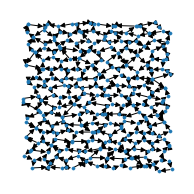

In [14]:
k='val2'
print('{}\n{} : {}\nsize:{}\n\nFrame 1:\n{}'.format(dataset_legend[k],k,datasets_dict[k],len(datasets_dict[k]),datasets_dict[k][0]))
plt.figure(figsize=[2.5,2.5])
nx.draw(to_networkx(datasets_dict[k][0]),pos=dict(enumerate(datasets_dict[k][0].pos.numpy())), node_size=10)

#### Helper functions

In [15]:
def plot_losses(train_log, loaders, dataset_legend,figsize=[15,8]):
    if figsize is not None:
        plt.figure(figsize=figsize)
    training_epochs = np.arange(train_log['total_epochs'])
    for data_name in loaders:
        plt.plot(training_epochs, train_log[f'{data_name}_loss_tot'],lw=3,label=f'{dataset_legend[data_name]}')
    plt.legend();


def plot_velocity_predictions(vel_pred, vel_tgt, dataset_legend, figsize=[15,7]):
    var_type = 0
    var_name = '$\Delta{}x$'

    for data_name in vel_pred:
        minY, maxY  = torch.cat(vel_tgt[data_name],dim=0).min(), torch.cat(vel_tgt[data_name],dim=0).max()

        fig,axs = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=figsize)    
        for k,ax in enumerate(axs):
            ax.plot([minY,maxY], [minY,maxY],'--',color='b',lw=2,alpha=.5)
            ax.plot(torch.cat(vel_tgt[data_name], dim=0)[:,k],
                    torch.cat(vel_pred[data_name], dim=0)[:,k], 'o',ms=10,mfc='tomato',alpha=.25)
            ax.set_xlabel('True');
            ax.set_ylabel('Predicted')
            ax.set_title(f'{var_name}$_{k}$');
        plt.suptitle(f'{dataset_legend[data_name]}')
        plt.show()

def plot_tension_prediction(t_pred, t_tgt, dataset_legend, figsize=[15,7]):
    var_name = 'Tension'

#### Persistence Loss

In [16]:
print('Persistence:')
for k in datasets_dict:
    if k=='abln':print('Ignoring ablation data velocity');continue
    print(f'\t- {dataset_legend[k]}: {persistence_loss(datasets_dict[k])}')

Persistence:
	- Train (sim1): {'mae': 0.06756853, 'mse': 0.008532567}
	- Val(sim1): {'mae': 0.06426177, 'mse': 0.007703601}
	- Val(sim2): {'mae': 0.063635536, 'mse': 0.008163488}
	- Hara: {'mae': 0.023777857, 'mse': 0.0009641348}
Ignoring ablation data velocity


In [17]:
len(datasets_dict['train'])

280

**To-Do**👷🚧
- need a func-n w/ a **rollout error**,
- convert vel-y error to **position error**
- *Training loop*:
    - [ ] Combine `Message` and `AggregateUpdate` into a graph layer `GraphBlock`
- [ ] Write *prediction stage*: read \{test, val, train\} data for rollout error measurements.
- [ ] Experiments (**save all models** w/ backups; will need to test on the real tensions)<br>
*Params*: edge attrib-s, cell layer, arch(skip con-s), input noise (for long term prediction). *Errors*: 1-step, and rollout error (check after training at test time).
    1. Experiment with GN arch-s w/ *residual* (w/ skip) and *non-residual* architectures.
    1. *Edge directions experiment*: train w/ and w/o edge dir-s, do edge dir-s help to speed up training?
    1. *Cell layer*: does having dedicated cell processing layer help to increase the accuracy?
    1. For best (resnet or non-resnet) run *number of layers and dim-n sizes*. Try deep nets, how does accuracy change with increasing the depth of the net?
    1. If resnet is better: try w/and w/o edge dir-s and "cell layers".
    1. Number of previous velocities (window size).
    1. Rollout experiment 1— *input noise*: according to Sanchez-Gonzalez, *et al.* \[ASG2020\], Brownian noise improves rollout accuracies (long term accuracy of the whole movie, and/or prediction stability/robustness).
    1. Rollout experiment 2— *rollout training*: train directly on rollout, i.e. use 5- and 10-step loss instead of a 1-step loss for training (slower training).
    1. Optional:
        - compare MLP vs CONV layers for message passing.
        - try with dynamic graphs (construct graphs on the fly based on relative positions, and use cell edges and cell attrib only for queries on `Y_edge`, `Y_cell`).
- [ ] Ablation dataset (*real*).

---
**DOING**🛠
1. Construct graph net without skip connections.
1. Combine Message and AggregateUpdate into a graph layer GraphNet (GN) block, a more general block, that can be composed into a deep residual network. "AddGN" block, w/ `AddGN(x) = f(x)+x` form (in fact, where it's possible make all blocks with this form.
1. Construct residual net out of GNs.
---

- **Examples**:
    - General "Message Passing" schemes: a nice example for composite graph layer –"meta layer" consisting of "edge", "node" and "global" layers [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer)

**Node-to-Cell Encoding/Pooling Layer**:
1. Initiate node-to-cell edge attr-s as (source) node attr-s `x[node2cell_index[0]]`.
1. Compute node-to-cell edge attr-s using MLP: `e_n2c = MLP( x[node2cell_index[0]] )`
1. Aggregate node-to-cell edge attr-s as cell attr-s : `x_cell = Aggregate(e_n2c)`
1. Compute new cell attr-s using (encodes `x_cell` into cell attr-s) : `h_cell = MLP_Cell_encoder( x_cell )`

```python
n2c_model = mlp(...) # "message", just node-wise MLP
cell_aggr = Aggregate()
cell_enc = mlp(...)

e_n2c = n2c_model(data.x)[data.node2cell_index[0]]
x_cell = cell_aggr(data.cell_pressures.size(0), data.node2cell_index, e_n2c)
h_cell = cell_enc(x_cell)
```

---
- **Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```

---

#### Single MP Step Tension Model

In [18]:
from simgnn.nn import SingleMP_Tension

In [20]:
torch.manual_seed(0)

dropout_p = 0
num_epochs = 30
lr = 0.001
bs = 4
# loss_func = torch.nn.MSELoss(reduction='mean')
loss_func = torch.nn.L1Loss(reduction='mean')

net = SingleMP_Tension(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                       message_out_features=32, message_hidden_dims=[64,32,32],
                       tension_hidden_dims=[32,16,8,4],
                       aggr='mean', update_hidden_dims=[32,32,16,8], dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr)
# opt = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = None
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs,follow_batch=['edge_index']),
           'val':    DataLoader(datasets_dict['val'], batch_size=bs),
           'val2':   DataLoader(datasets_dict['val2'], batch_size=bs,follow_batch=['edge_index']),
           'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {'train':[True,False], 
                  'val':[True, False],
                  'val2':[True,False] ,
                  'hara' : [False, False]
                 }# [tension, pressure]

return_best = False

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'
save_dir = './simgnn_data/saved_models/'

In [21]:
print(model_name,end='\n---\n')

net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=scheduler, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss, return_best=return_best)

20082021_055156_SingleMP_Tension_dp0bs4w5
---
Training param-s: #epochs=30, metric=L1Loss(), batch_size=4, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/29: train_loss_tot=   1.957; train_loss_y=  0.1032; train_loss_T=   1.854; |val_loss_tot=   1.811; |val2_loss_tot=  0.7843; |hara_loss_tot= 0.02455; |4s
Epoch 1/29: train_loss_tot=   1.809; train_loss_y= 0.05645; train_loss_T=   1.752; |val_loss_tot=   1.679; |val2_loss_tot=  0.7962; |hara_loss_tot= 0.01694; |7s
Epoch 2/29: train_loss_tot=   1.289; train_loss_y= 0.04373; train_loss_T=   1.245; |val_loss_tot=  0.8963; |val2_loss_tot=   1.803; |hara_loss_tot= 0.01502; |10s
Epoch 3/29: train_loss_tot=  0.8928; train_loss_y= 0.03726; train_loss_T=  0.8556; |val_loss_tot=  0.8663; |val2_loss_tot=   1.681; |hara_loss_tot=  0.0145; |13s
Epoch 4/29: train_loss_tot=  0.8747; train_loss_y= 0.03395; train_loss_T=  0.8408; |val_loss_tot=   0.844; |val2_loss_tot=   1.649; |hara_loss_tot= 0.01498; |16s
Epoch 5/29: train_loss_tot=  0.8356; tr

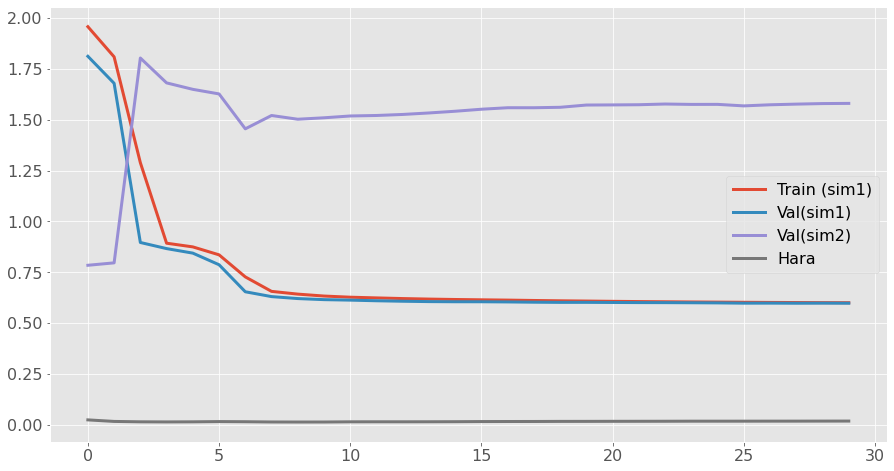

- train_loss_tot =0.5906888224992407;
- train_loss_y =0.0012419079115819475;
- train_loss_T =0.5895471117426618;
- train_loss_P =None;
- val_loss_tot =0.585189129039157;
- val_loss_y =0.0010671540144995724;
- val_loss_T =0.5840938130871204;
- val_loss_P =None;
- val2_loss_tot =2.902470804732025;
- val2_loss_y =0.0017403527372083702;
- val2_loss_T =2.9007333039458514;
- val2_loss_P =None;
- hara_loss_tot =0.000613576998852559;
- hara_loss_y =0.000613576998852559;
- hara_loss_T =None;
- hara_loss_P =None;



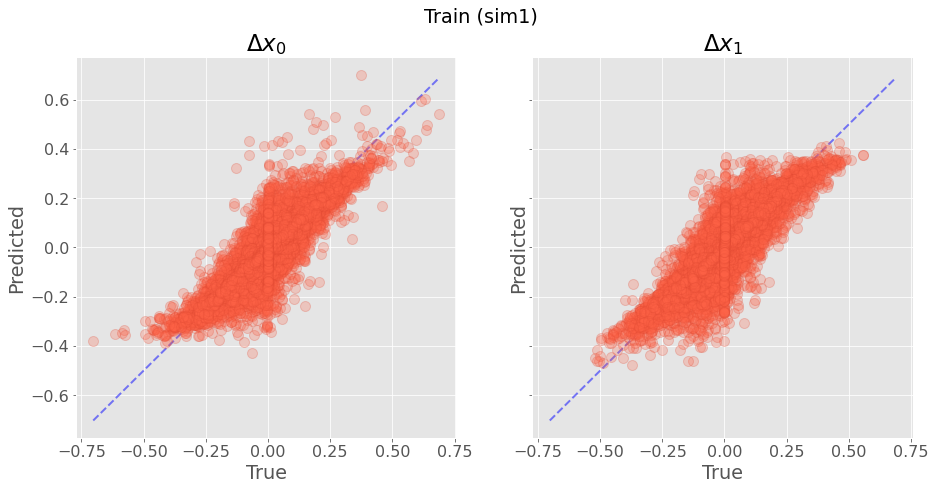

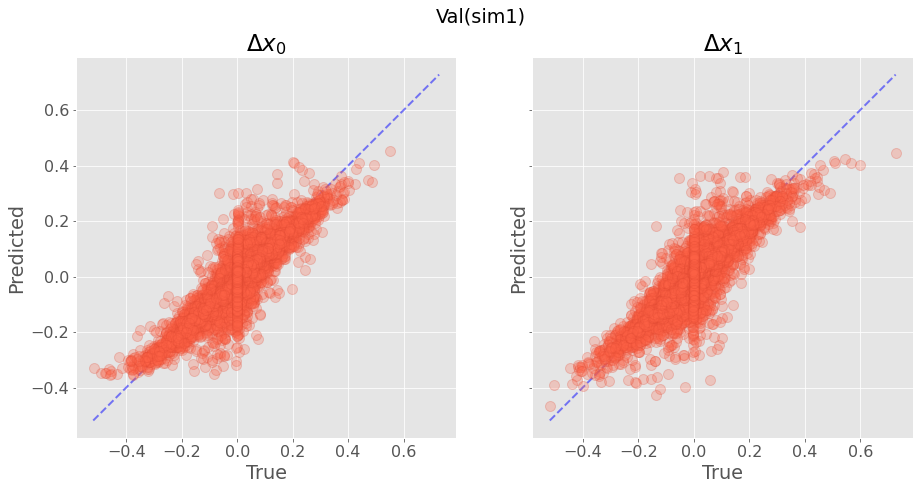

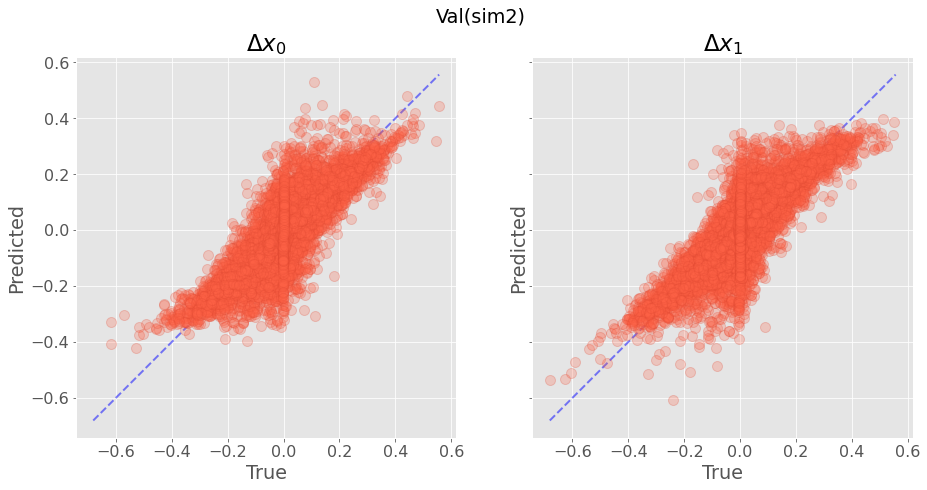

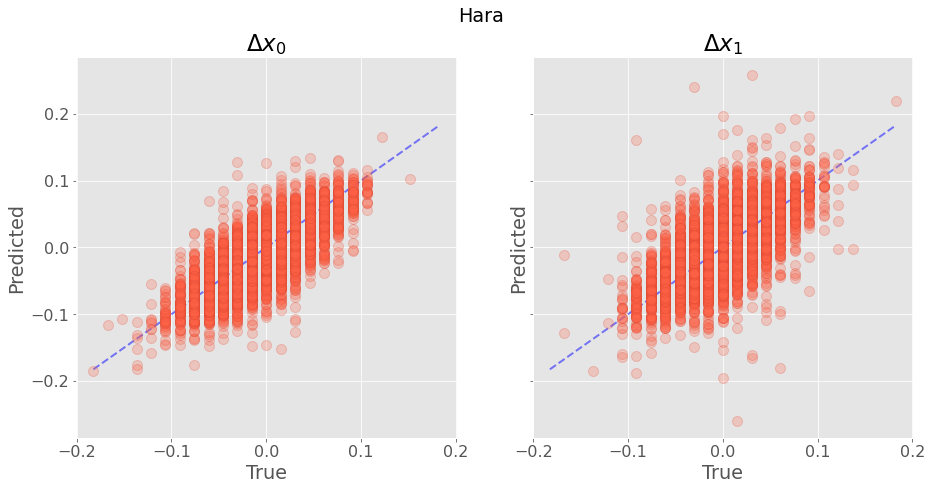

In [24]:
# plot losses
plot_losses(train_log, loaders, dataset_legend); plt.show()

# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='mean'),
                                                 use_force_loss = use_force_loss, return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [30]:
predict_batch?

Signature:
predict_batch(
    model,
    data_loaders,
    loss_func=L1Loss(),
    use_force_loss={'train': [True, True], 'val': [True, True], 'hara': [False, False]},
    return_losses=True,
    device=device(type='cpu'),
)
Docstring:
Returns:
- outputs : tuple (X_vel, E_tens, C_pres)
- targets : tuple (X_vel_targets, E_tens_targets, C_pres_targets) 
- running_losses : dict of losses for input dataset loaders. Returns if return_losses is "True".
File:      /mnt/mbi/images/toyama/murat/codesDIR/simgnn/nbs/simgnn/train.py
Type:      function


In [36]:
tgt_out[1]['val']

[tensor([1.7207, 0.2620, 1.1430,  ..., 2.0859, 2.0095, 3.9659]),
 tensor([2.7128, 3.4700, 1.3850,  ..., 2.0296, 4.4213, 0.9327]),
 tensor([3.3245, 5.6279, 1.9396,  ..., 1.9660, 4.2631, 4.0125]),
 tensor([2.7714, 3.2036, 2.5840,  ..., 1.9000, 1.8605, 2.2652]),
 tensor([1.7550, 0.1536, 3.0566,  ..., 1.8330, 2.1749, 1.8709]),
 tensor([1.5657, 1.4555, 3.1679,  ..., 1.7637, 4.5561, 4.2176]),
 tensor([2.4320, 4.9686, 2.8659,  ..., 1.6968, 4.0884, 0.9779]),
 tensor([3.2323, 4.9307, 2.2596,  ..., 1.6282, 1.7365, 3.6470]),
 tensor([2.9386, 1.3869, 1.6025,  ..., 1.5629, 2.3590, 2.7566]),
 tensor([1.9265, 0.1240, 1.1794,  ..., 1.5055, 4.6708, 1.4672]),
 tensor([1.4851, 3.2104, 1.1455,  ..., 1.4505, 3.8944, 4.3536]),
 tensor([2.1725, 5.6075, 1.4867,  ..., 1.4016, 1.6337, 1.1723]),
 tensor([3.1294, 3.4144, 2.0852,  ..., 1.3643, 2.5590, 3.2036]),
 tensor([3.1260, 0.2006, 2.6928,  ..., 1.3358, 4.7591, 3.2367]),
 tensor([0.3138, 2.9786, 1.1975,  ..., 1.2580, 0.0607, 0.9628]),
 tensor([0.3179, 2.4935, 

In [31]:
pred_out[1]

{'train': [tensor([0.8149, 3.4528, 1.7073,  ..., 0.8552, 1.1271, 1.8233]),
  tensor([1.0902, 2.8584, 0.8279,  ..., 1.1534, 1.1644, 1.6454]),
  tensor([2.6314, 2.3997, 0.4749,  ..., 1.1758, 1.2429, 1.8701]),
  tensor([3.5956, 1.9941, 0.5033,  ..., 1.1579, 1.2934, 1.9423]),
  tensor([3.0678, 2.1777, 1.1586,  ..., 1.0491, 1.5626, 1.4510]),
  tensor([2.4643, 1.8865, 2.6391,  ..., 0.8866, 1.9336, 1.3774]),
  tensor([2.4365, 1.6817, 3.9432,  ..., 0.9281, 2.1106, 1.8680]),
  tensor([1.5203, 2.6872, 3.3201,  ..., 0.7258, 2.3304, 1.7302]),
  tensor([0.8598, 2.3098, 2.4592,  ..., 0.7306, 2.5016, 1.6690]),
  tensor([0.9783, 2.0261, 2.4471,  ..., 0.6066, 2.3686, 1.7468]),
  tensor([1.8542, 1.9029, 2.1170,  ..., 0.5094, 2.4085, 1.3865]),
  tensor([4.1137, 1.4499, 1.1902,  ..., 0.4741, 2.4049, 1.6833]),
  tensor([3.6584, 1.7025, 1.1750,  ..., 0.6357, 2.3906, 2.5409]),
  tensor([2.4412, 1.6905, 1.1242,  ..., 0.5428, 2.3855, 1.8807]),
  tensor([0.9655, 1.4885, 0.4911, 1.3328, 0.6305, 2.7881, 2.3497, 1